In [1]:
install.packages("PoisNor")
install.packages("psych")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘mvtnorm’, ‘corpcor’




In [3]:
library("PoisNor")
library("psych")

Loading required package: mvtnorm

Loading required package: corpcor

Loading required package: Matrix



In [4]:
num_cell_types_pois = 2
num_cell_types_dummy = 1 # needed for normal samples in PoisNor
num_cell_types = num_cell_types_pois + num_cell_types_dummy
num_frames = 100
num_readers = 5
main_cell_type_rates = c(21, 9, 0)
corMat = diag(1, num_cell_types, num_cell_types)
corMat[lower.tri(corMat)] = 0.3
corMat[upper.tri(corMat)] = 0.3
corMat[1:num_cell_types_pois, num_cell_types] = 0
corMat[num_cell_types, 1:num_cell_types_pois] = 0

In [5]:
# Sample counts per regions (frames) from a given correlation matrix
# Input:
#   rate_mat: a vector of counts per frame (rates) for each cell type
#   num_cell_types: the number of cell types
#   num_frames: the number of frames to generate
#   corMat: the correlation matrix of cell types
#   num_dummy: the number of dummy variables to add
# Output:
#   frames_pois: a matrix of Poisson distributed cell counts
sample_frames = function(rate_mat, num_cell_types, num_frames, corMat, num_dummy) {
  num_pois = num_cell_types - num_dummy
  normal_vars = rep(0, num_dummy)
  cmat = cmat.star(num_pois, num_dummy, corMat, rate_mat)
  frames = genPoisNor(num_frames, num_dummy, num_pois, cmat, rate_mat, normal_vars, normal_vars)
  frames_pois = frames[1:num_frames, 1:num_pois]
  return(frames_pois)
}

# Sample counts per regions (frames) per pathologist from a given correlation matrix
# Input:
#   num_frames: integer representing the number of frames for each path.
#   frames: numeric matrix with dimensions `num_frames` x `num_cell_types`, representing the ground truth cell counts for each cell type at each frame.
#   noise_range: either vectore or float representing the range or rate of noise for each pathologist estimate
#   corMat: numeric matrix with dimensions `num_cell_types` x `num_cell_types`, representing the correlation matrix for each cell type.
#   num_readers: integer representing the number of pathologists.
# Output:
#   path_table: numeric matrix with dimensions `num_frames` x `num_cell_types*num_readers`, representing the generated reader counts
sample_path_frames = function(num_frames, frames, noise_range, corMat, num_readers){
  num_cell_types = ncol(frames)
  num_dummy = 1
  path_table = matrix(, nrow=num_frames, ncol=(num_cell_types*num_readers))
  for (path in 1:num_readers) {
    path_per_frames = matrix(, nrow=num_frames, ncol=(num_cell_types+num_dummy))
    for (frame in 1:num_frames){
      curr_frame = frames[frame, 1:num_cell_types]
      normal_vars = rep(0, num_dummy)
      # noise = sample(noise_range, num_cell_types, replace=TRUE)
      noise = rpois(1, noise_range) - noise_range # scaled poisson noise
      rate_mat = curr_frame + noise
      rate_mat = pmax(rate_mat, rep(1, num_cell_types))
      cmat = cmat.star(num_cell_types, num_dummy, corMat, rate_mat)
      path_per_frames[frame, 1:(num_cell_types+num_dummy)] = genPoisNor(1, num_dummy, num_cell_types, cmat, rate_mat, normal_vars, normal_vars)
    }
    path_table[1:num_frames, (path*num_cell_types-1):(path*num_cell_types)] = path_per_frames[1:nrow(path_per_frames), 1:num_cell_types]
  }
  return(path_table)
}

# Performs bootstrapping to estimate correlation measures between consensus measurements and ground truth measurements.
# Input:
#   replicates (integer): The number of times to perform bootstrapping.
#   frames (data frame): A data frame containing the ground truth measurements for all cells.
#   path_frames (data frame): A data frame containing pathologist counts for all cells.
#   num_readers (integer): The number of pathologist.
#   consensus_funcs (list): A list of functions that will be used to aggregate measurements across readers.
# Output:
#   A 4D array containing correlation measures between consensus measurements and ground truth measurements for each cell type, consensus function, and agreement measure (Pearson and Cohen's Kappa).
bootstrap = function(replicates, frames, path_frames, num_readers, consensus_funcs) {
  num_cell_types = ncol(frames)
  consensus_names = names(consensus_funcs)
  boot_corrs = array(, dim=c(replicates, num_cell_types, length(consensus_names), 2))
  for (rep in 1:replicates) {
    subset_indeces = sample(1:num_frames, num_frames, replace=TRUE)
    subset = path_frames[subset_indeces, 1:ncol(path_frames)]
    for (cell in 1:num_cell_types){
      per_cell = subset[1:nrow(subset), seq(cell, ncol(subset), num_cell_types)]
      for (c in 1:length(consensus_names)) {
        conensus_per_frames = apply(per_cell, 1, consensus_names[c], na.rm=TRUE)
        boot_corrs[rep, cell, c, 1] = cor(frames[subset_indeces, cell], conensus_per_frames, method='pearson')
        boot_corrs[rep, cell, c, 2] = cohen.kappa(cbind(frames[subset_indeces, cell], conensus_per_frames))$kappa
      }
    }
  }
  return(boot_corrs)
} 

# Computes confidence interval
# Input:
#   corrs (4D array): A 4-dimensional array containing the correlation coefficients computed for each combination of cell types, consensus function, and correlation method.
#   alpha (numeric): A numeric value that specifies the significance level of the confidence intervals.
# Output:
#   cis (4D array): A 4-dimensional array containing the lower and upper bounds of the confidence intervals for each combination of cell types, consensus function, and correlation method.
ci = function(corrs, alpha) {
  num_cell_types = ncol(corrs)
  num_consensus = dim(corrs)[3]
  num_measures = 2
  cis = array(, dim=c(num_cell_types, 2, num_consensus, num_measures))
  for (cell in 1:num_cell_types) {
    for (c in 1:num_consensus) {
      for (m in 1:num_measures){
        sorted = sort(corrs[1:nrow(corrs), cell, c, m], decreasing=FALSE)
        cis[cell, 1:2, c, m] = c(sorted[round(alpha/2*nrow(corrs))], sorted[round((1-alpha/2)*nrow(corrs))])
      }
    }
  }
  return(cis)
}

# Computes mode
# Input:
#   v (vector): A vector of numeric values.
#   na.rm (logical): A logical value indicating whether missing values should be removed before computing the mode.
# Output:
#   The mode of the vector v
mode = function(v, na.rm) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

# Computes accelaration constant used to find bias-corrected confidence interval
# Input:
#   gt (vector): A vector of the ground truth values.
#   pred (matrix): A matrix of the predicted values.
#   theta_hat (numeric): The correlation coefficient for the original samples
# Output:
#   a_hat (numeric): The acceleration constant for the accelerated bootstrap confidence intervals.
acceleration_const = function(gt, pred, theta_hat) {
  n = length(gt)
  I = rep(NA, n)
  for(i in 1:n){
    # Remove ith data point
    gt_new = gt[-i]
    pred_new = pred[-i]
    # Estimate theta
    theta_jack = cor(gt_new, pred_new)
    I[i] = (n-1)*(theta_hat - theta_jack)
  }
  # Estimate a
  a_hat = (sum(I^3)/sum(I^2)^1.5)/6
  return(a_hat)
}

# Computes bias corrected confidence interval
# Input:
#   gt (matrix): A matrix of the ground truth values.
#   pred (matrix): A matrix of the predicted values.
#   corrs (4D array): A 4-dimensional array containing the correlation coefficients computed for each combination of cell types, consensus function, and correlation method.
#   alpha (numeric): A numeric value that specifies the significance level of the confidence intervals.
#   consensus_funcs (list): A list of functions used to compute consensus values.
# Output:
#   cis (4D array): A 4-dimensional array containing the lower and upper bounds of the confidence intervals for each combination of cell types, consensus function, and correlation method.
accelerated_ci = function(gt, pred, corrs, alpha, consensus_funcs) {
  # Desired quantiles
  u <- c(alpha/2, 1-alpha/2) 
  num_cell_types = ncol(gt)
  num_consensus = dim(corrs)[3]
  num_measures = 2
  consensus_names = names(consensus_funcs)
  cis = array(, dim=c(num_cell_types, 2, num_consensus, num_measures))
  # Compute constants
  for (cell in 1:num_cell_types) {
    per_cell = pred[1:nrow(pred), seq(cell, ncol(pred), num_cell_types)]
    for (c in 1:num_consensus) {
      conensus_per_frames = apply(per_cell, 1, consensus_names[c], na.rm=TRUE)
      theta_hat = cor(gt[1:nrow(gt), cell], conensus_per_frames)
      a <- acceleration_const(gt[1:nrow(gt), cell], conensus_per_frames, theta_hat)
      for (m in 1:num_measures){
        # Desired quantiles
        u <- c(alpha/2, 1-alpha/2) 
        # Compute constants
        z0 <- qnorm(mean(corrs[1:nrow(corrs), cell, c, m] <= theta_hat))
        zu <- qnorm(u) 
        # Adjusted quantiles
        u_adjusted <- pnorm(z0 + (z0 + zu) / (1 - a * (z0 + zu))) 
        # Accelerated Bootstrap CI
        quantile(corrs[1:nrow(corrs), cell, c, m], u_adjusted)
        # Accelerated Bootstrap CI
        cis[cell, 1:2, c, m] = quantile(corrs[1:nrow(corrs), cell, c, m], u_adjusted)
      }
    }
  }
  return(cis)
}

Sampling can take a while to run, so sample once and save.

In [6]:
frames = sample_frames(main_cell_type_rates[1:num_cell_types_pois], num_cell_types, num_frames, corMat, num_cell_types_dummy)

.........
.........
......
......


In [7]:
write.csv(frames, "frames.csv", row.names=FALSE)

In [8]:
# noise_range = -1:1 # for uniform
noise_range = 3 # for poisson
path_frames = sample_path_frames(num_frames, frames, noise_range, corMat, num_readers)

.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
.........
......
......
.........
....

In [9]:
write.csv(path_frames, "path_frames.csv", row.names=FALSE)

Read in the saved samples

In [10]:
gt = read.csv(file = "/content/frames.csv")
pred = read.csv(file = "/content/path_frames.csv")

, , 1, 1

          [,1]      [,2]
[1,] 0.8251471 0.9191972
[2,] 0.8524318 0.9394801

, , 2, 1

          [,1]      [,2]
[1,] 0.7784150 0.9017830
[2,] 0.8124751 0.9238131

, , 3, 1

          [,1]      [,2]
[1,] 0.5445743 0.7709556
[2,] 0.5897703 0.8040282

, , 1, 2

             [,1]       [,2]
[1,] -0.005530417 0.06340058
[2,]  0.014427962 0.11385884

, , 2, 2

           [,1]      [,2]
[1,] 0.01483051 0.1599319
[2,] 0.09831613 0.2778993

, , 3, 2

             [,1]       [,2]
[1,] -0.026237833 0.08247205
[2,]  0.002360009 0.15254237



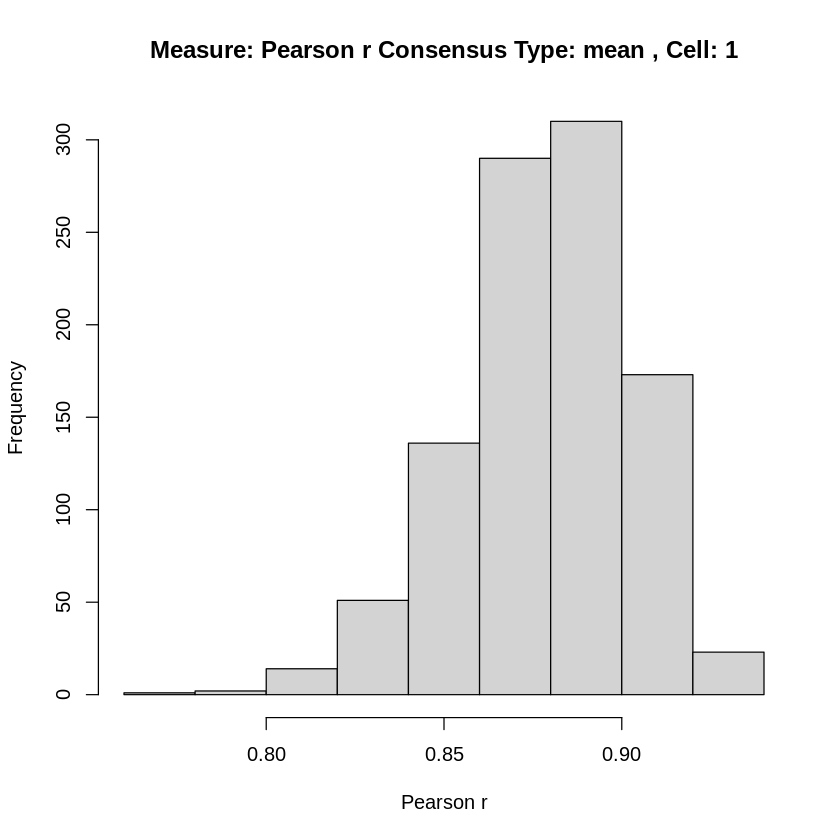

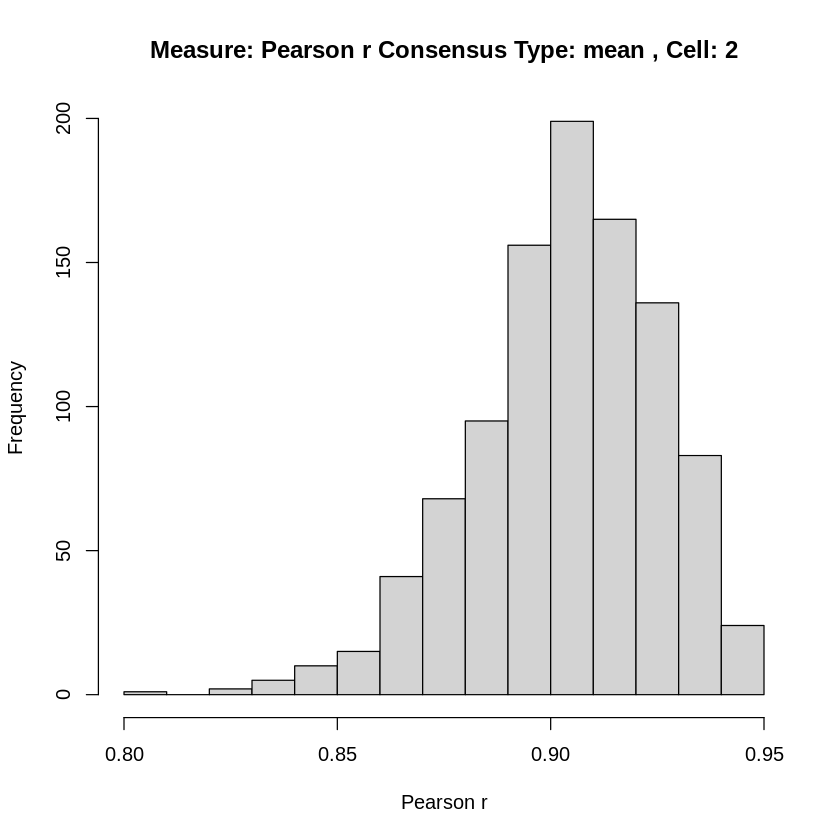

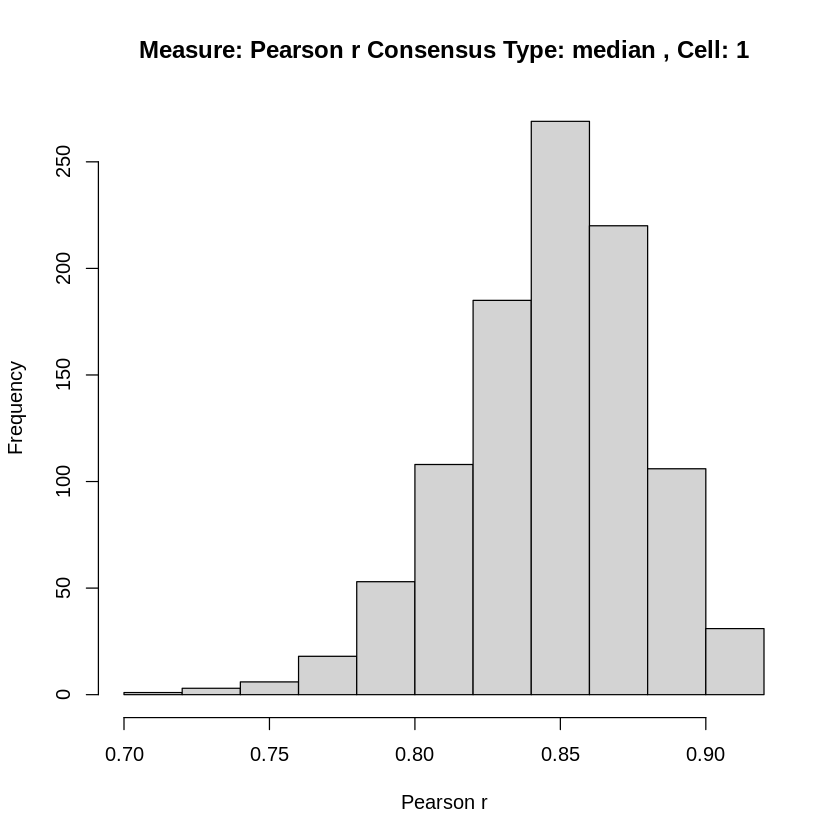

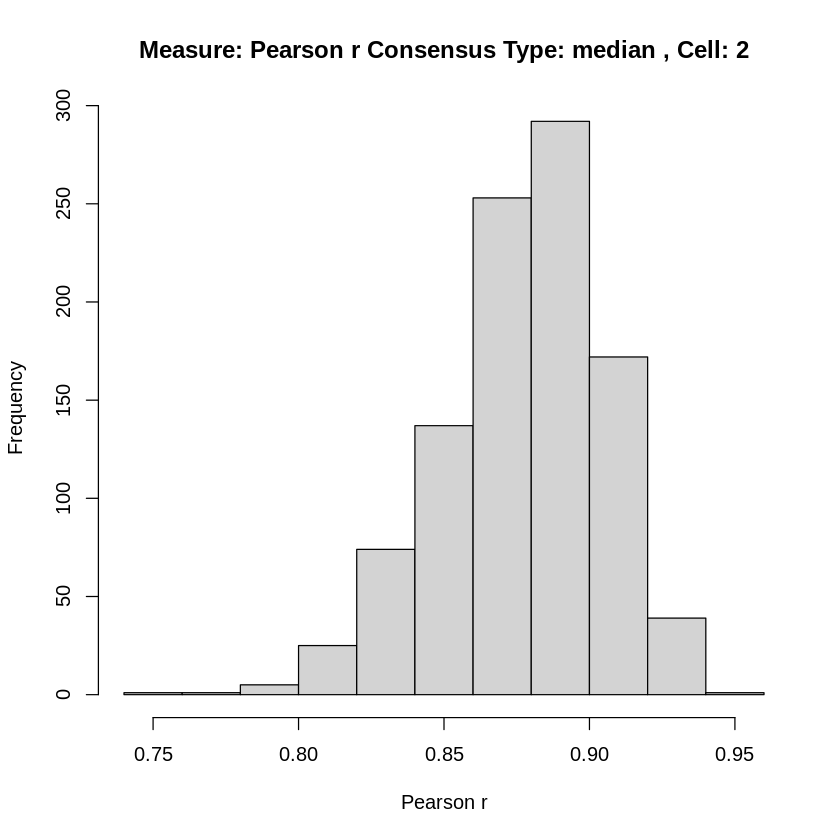

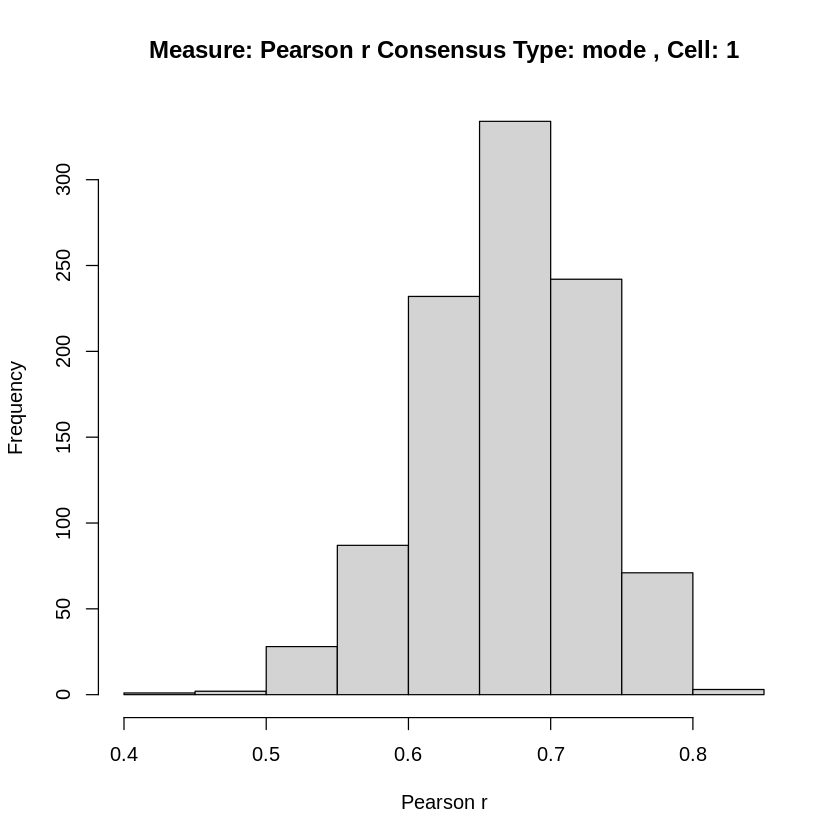

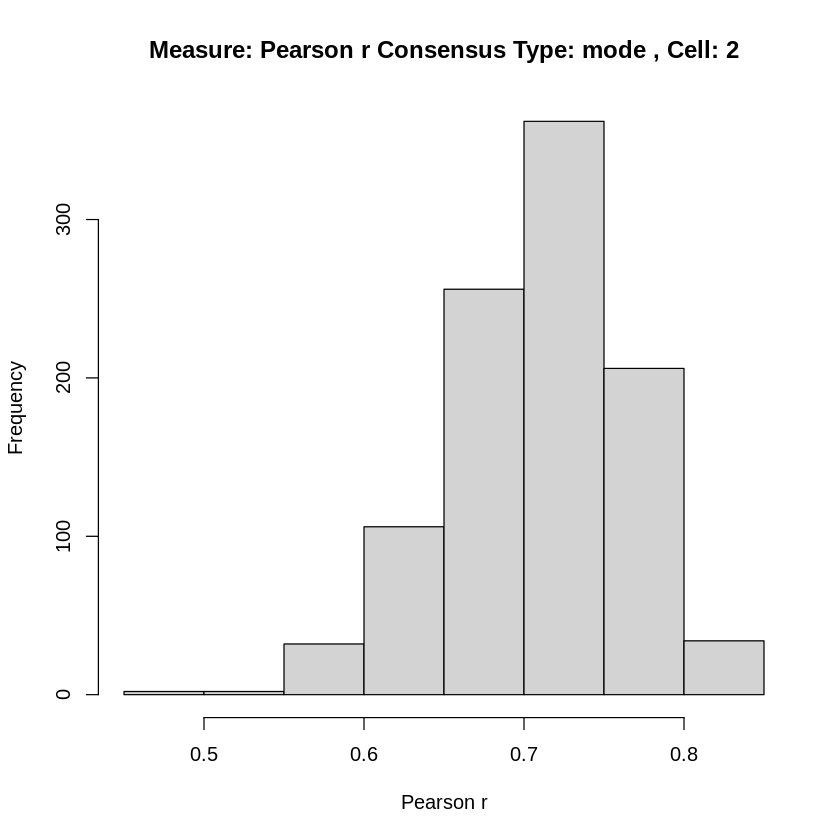

In [16]:
replicates = 1000
num_measures = 2
consensus_funcs = list("mean"=mean, "median"=median, "mode"=mode)
consensus_names = names(consensus_funcs)
measures = c("Pearson r", "Cohen Kappa")
boot_corrs = bootstrap(replicates, gt, pred, num_readers, consensus_funcs)
print(ci(boot_corrs, 0.05))
for (m in 1:1) { # only look at correlation not cohen kappa
  for (c in 1:length(consensus_names)) {
    for (cell in 1:num_cell_types_pois) {
      hist(boot_corrs[1:nrow(boot_corrs), cell, c, m], main=paste("Measure:", measures[m], "Consensus Type:", consensus_names[c], ", Cell:", as.character(cell)), xlab="Pearson r")
    }
  }
}

# output cis:
# Pearson r
#   Mean
#     cell 1
#     cell 2
#   Median
#     cell 1
#     cell 2
#   Mode
#     cell 1
#     cell 2
# Cohen K
#   Mean
#     cell 1
#     cell 2
#   Median
#     cell 1
#     cell 2
#   Mode
#     cell 1
#     cell 2

Compute the bias corrected confidence intervals for correlation only

In [17]:
aci = accelerated_ci(gt, pred, boot_corrs, 0.05, consensus_funcs)

In [18]:
print(aci)

, , 1, 1

          [,1]      [,2]
[1,] 0.8254493 0.9189746
[2,] 0.8501781 0.9373208

, , 2, 1

          [,1]      [,2]
[1,] 0.7782781 0.9008622
[2,] 0.8086227 0.9220856

, , 3, 1

          [,1]      [,2]
[1,] 0.5462463 0.7733389
[2,] 0.5841933 0.7974674

, , 1, 2

     [,1] [,2]
[1,]  NaN  NaN
[2,]  NaN  NaN

, , 2, 2

     [,1] [,2]
[1,]  NaN  NaN
[2,]  NaN  NaN

, , 3, 2

     [,1] [,2]
[1,]  NaN  NaN
[2,]  NaN  NaN

